# Tsodyks-Markram model of short-term synaptic plasticity
In this notebook we demonstrate how to fit the parameters of the Tsodyks-Markram model to a given in vitro somatic recording. The in vitro trace used here shows a typical L5TTPC-L5TTPC depressing connection, kindly provided by Rodrigo Perin (EPFL).

`tmodeint.py` numerically integrates the "full version" of the TM model and fits a postsynaptic voltage trace:

\begin{equation}
\frac{dR(t)}{dt} = \frac{1-R(t)-E(t)}{D} - U(t)R(t)\delta(t-t_{spike})
\end{equation}
\begin{equation}
\frac{dU(t)}{dt} = \frac{U_{SE}-U(t)}{F} + U_{SE}(1-U(t))\delta(t-t_{spike})
\end{equation}
\begin{equation}
\frac{dE(t)}{dt} = \frac{-E}{\tau_{inac}} + U(t)R(t)\delta(t-t_{spike})
\end{equation}
\begin{equation}
\tau_{mem} \frac{dV(t)}{dt} = -V + R_{inp}I_{syn}(t)
\end{equation}
where $I_{syn}(t)=A_{SE}E(t)$

In /home/miseno/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/miseno/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/miseno/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/miseno/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/miseno/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


<IPython.core.display.Javascript object>


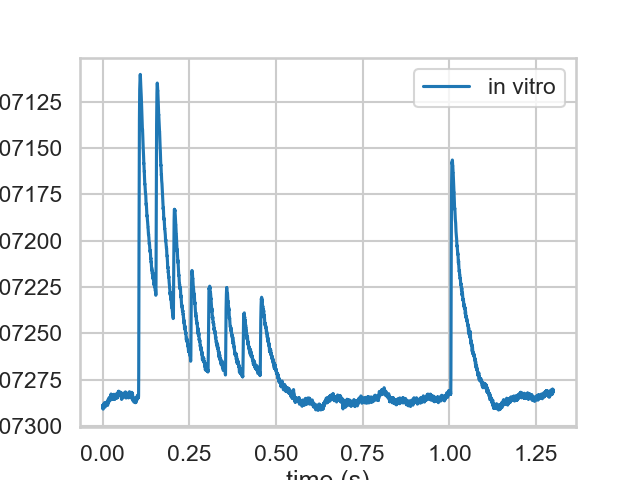

Text(0, 0.5, 'soma voltage (V)')

In [1]:
%matplotlib nbagg
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pickle
import tmevaluator
import bluepyopt as bpop
import numpy as np

# Set plotting context and style
sns.set_context('talk')
sns.set_style('whitegrid')

# Load and display in vitro trace
trace = pickle.load(open('trace.pkl', 'rb'), encoding='latin1')
#trace = pickle.load(open('trace.pkl'))

'''
with open('data.pkl', 'rb') as f:
    trace = pickle.load(f)
'''

#trace = pickle.load(open('data.pkl'))

fig, ax = plt.subplots()
ax.plot(trace['t'], trace['v'], label='in vitro')
ax.legend(loc=0)
ax.set_xlabel('time (s)')
ax.set_ylabel('soma voltage (V)')

We now estimate the parameters of the Tsodyks-Markram model using BluePyOpt.

In [3]:
# Parameters to be fitted as a list of: (name, lower bound, upper bound)
optconf = [('trec', 1.0, 1000.0),
           ('tfac', 1.0, 1000.0),
           ('ase', 100.0, 10000.0),
           ('use', 0.01, 1.0),
           ('rinput', 10.0, 300.0),
           ('tmem', 10.0, 100.0),
           ('tinac', 0.1, 30.0),
           ('latency', 0.0, 10.0)]
pnames = [name for name, _, _ in optconf]

# Create multiprocessing pool for parallel evaluation of fitness function
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# Create BluePyOpt optimization and run 
evaluator = tmevaluator.TsodyksMarkramEvaluator(trace['t'], trace['v'], trace['tstim'], optconf)
opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=500, map_function=pool.map,
                                          eta=20, mutpb=0.3, cxpb=0.7)
pop, hof, log, history = opt.run(max_ngen=50)

# Get best individual
best = hof[0]
for pname, value in zip(pnames, best):
    print('%s = %.2f' % (pname, value))

trec = 415.56
tfac = 163.12
ase = 1877.15
use = 0.52
rinput = 51.82
tmem = 32.79
tinac = 1.27
latency = 4.21


Finally we compare the original in vitro trace with the one generated by the best model.

<IPython.core.display.Javascript object>


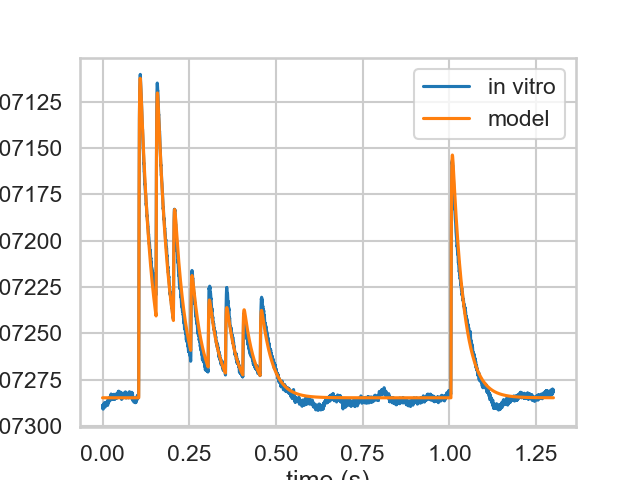

Text(0, 0.5, 'soma voltage (V)')

In [4]:
# Get v trace for best model
vmodel = evaluator.generate_model(best)

fig, ax = plt.subplots()
ax.plot(trace['t'], trace['v'], label='in vitro')
ax.plot(trace['t'], vmodel, label='model')
ax.legend(loc=0)
ax.set_xlabel('time (s)')
ax.set_ylabel('soma voltage (V)')